In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.


Could not locate executable gfortran
Could not locate executable f95
Could not locate executable g95
Could not locate executable efort
Could not locate executable efc
Could not locate executable flang
don't know how to compile Fortran code on platform 'nt'


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.random.seed(10)

In [3]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(5, grid_points)


def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    """
    Returns Double Exponential prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Double Exponential density of prior values
    """
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

In [4]:
def binom_post_grid_approx(prior_func, grid_points=5, water=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(water, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [74]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, water=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

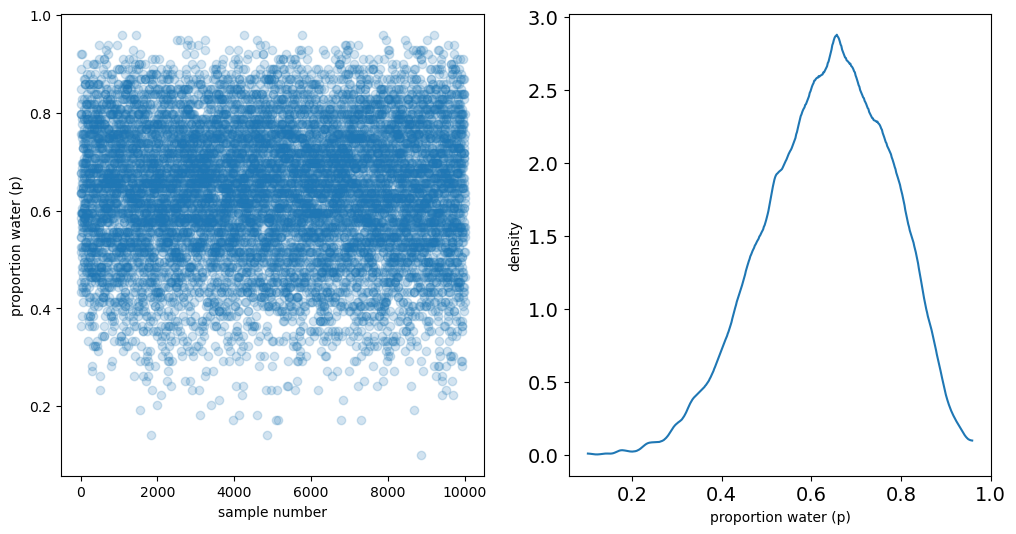

In [75]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density");

### 3E1. How much posterior probability lies below p = 0.2?

In [76]:
sum(samples<0.2)/1e4

0.0013

### 3E2.How much posterior probability lies above p=0.8?

In [77]:
sum(samples>0.8)/1e4

0.1184

### 3E3. How much posterior probability lies between p=0.2 and p=0.8?

Answer: (1) by definition and (4) by Bayes'theorem

In [78]:
sum((samples < 0.8) & (samples > 0.2)) / 1e4

0.8803

### 3E4. 20% of the posterior probability lies below which value of p?

In [79]:
np.percentile(samples,20)

0.5151515151515152

### 3E5. 20% of the posterior probability lies above which value of p?

In [80]:
np.percentile(samples,80)

0.7575757575757577

### 3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [81]:
az.hdi(samples, hdi_prob=0.66)

array([0.50505051, 0.77777778])

### 3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [82]:
az.hdi(samples, hdi_prob=0.66)

array([0.50505051, 0.77777778])

### 3M1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

In [83]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, water=8, tosses=15)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

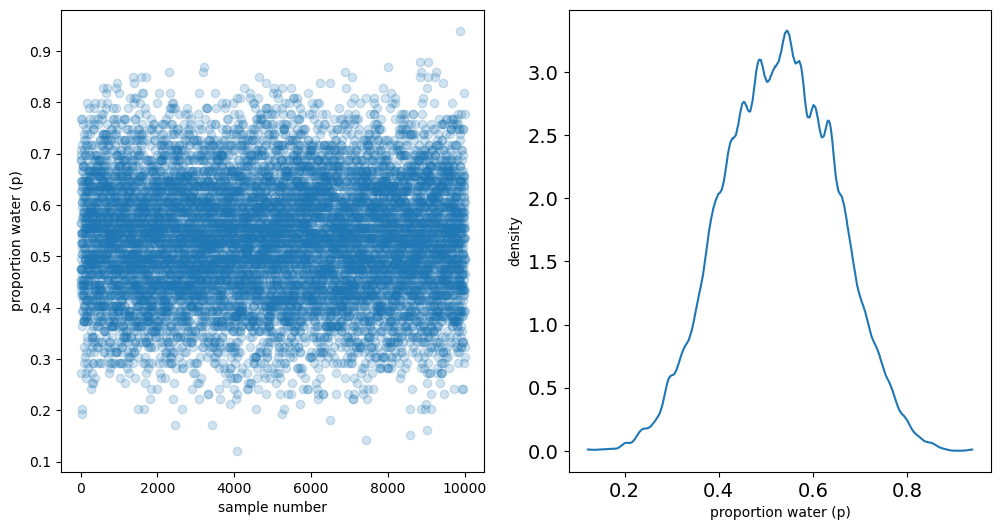

In [66]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density");

In [67]:
az.hdi(samples, hdi_prob=0.90)

array([0.34343434, 0.72727273])

### 3M3. Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing 8 water in 15 tosses?

In [68]:
s = np.random.binomial(15, samples, 10000)

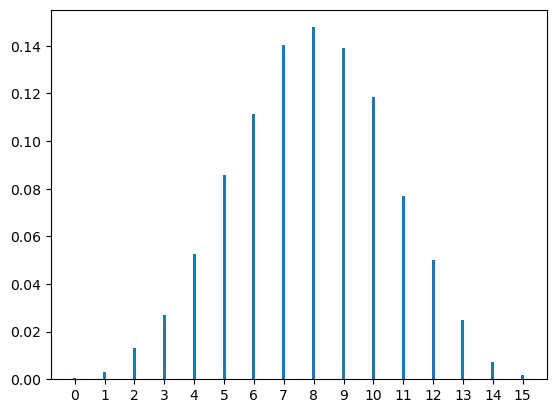

In [69]:
ax = az.plot_dist(s, kind="hist", hist_kwargs={"rwidth": 0.1})
plt.show()

In [70]:
np.count_nonzero(s== 8)/1e4

0.1478

### 3M4  Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [71]:
s = np.random.binomial(9, samples, 10000)

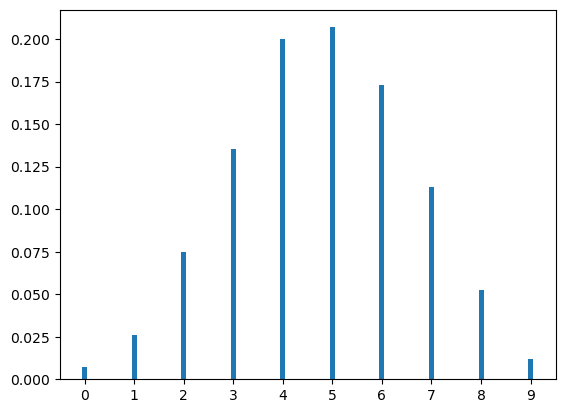

In [72]:
ax = az.plot_dist(s, kind="hist", hist_kwargs={"rwidth": 0.1})
plt.show()

In [73]:
np.count_nonzero(s== 6)/1e4

0.1727

### 3M5  Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each problem above and compare the inferences. What difference does the better prior make? If it helps, compare inferences (unsing both priors) to the true value p = 0.7.

In [92]:
p_grid, posterior = binom_post_grid_approx(truncated_prior, grid_points=100, water=8, tosses=15)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

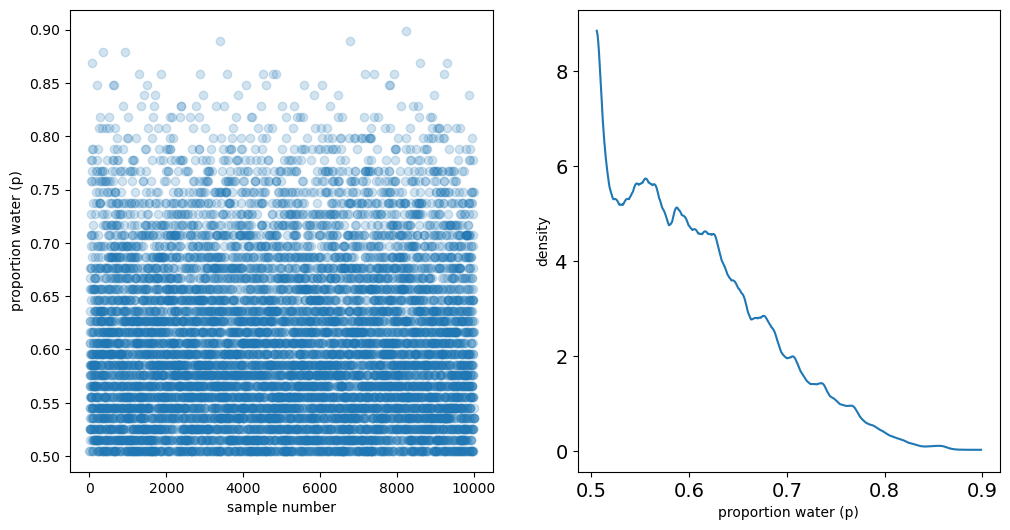

In [103]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density");

In [94]:
az.hdi(samples, hdi_prob=0.90)

array([0.50505051, 0.71717172])

In [95]:
s = np.random.binomial(15, samples, 10000)

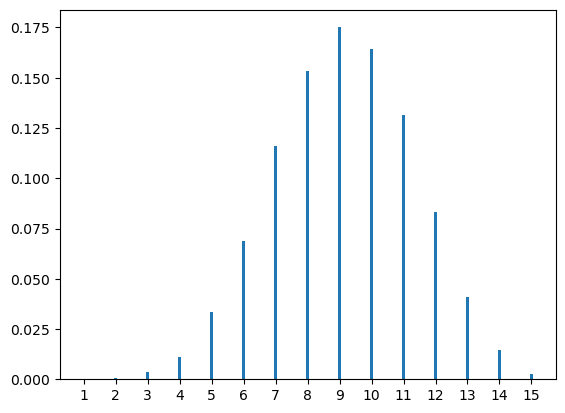

In [96]:
ax = az.plot_dist(s, kind="hist", hist_kwargs={"rwidth": 0.1})
plt.show()

In [97]:
np.count_nonzero(s== 8)/1e4

0.1532

In [98]:
s = np.random.binomial(9, samples, 10000)

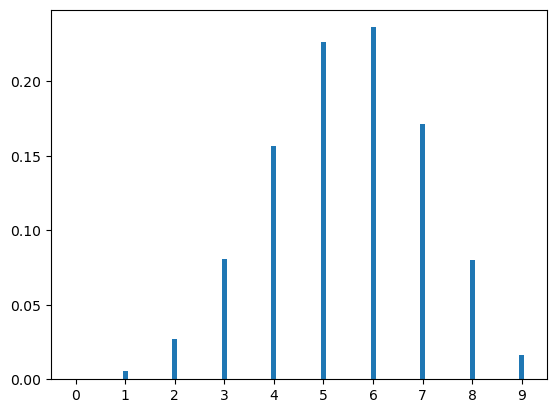

In [99]:
ax = az.plot_dist(s, kind="hist", hist_kwargs={"rwidth": 0.1})
plt.show()

In [100]:
np.count_nonzero(s== 6)/1e4

0.2362

In [101]:
az.summary(s)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,5.46,1.583,3.0,8.0,0.016,0.011,9844.0,9412.0,NaN


### 3H1 The practice problems here all use the data below. These data indicate the gender (male = 1, female = 0) of officially reported first and second born children in 100 two-child families.

In [84]:
birth1 = [
    1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
    0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
    1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
    0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
]
birth2 = [
    0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
    0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
]

In [104]:
sum(birth1+birth2)

111

### 3H1 Using grid approximation, compute the posterior distribution for the probability of a birth being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior probability?

In [105]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=1000, water=111, tosses=200)

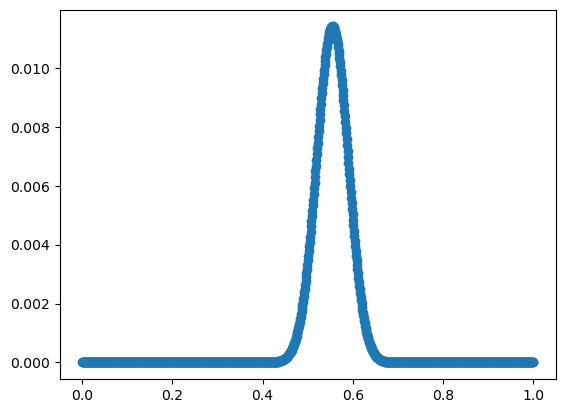

In [108]:
_, ax = plt.subplots()

ax.plot(p_grid, posterior, 'o-')


### 3H2. Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these sample to estimate the 50%, 89%, and 97% highest posterior density intervals. 

In [122]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

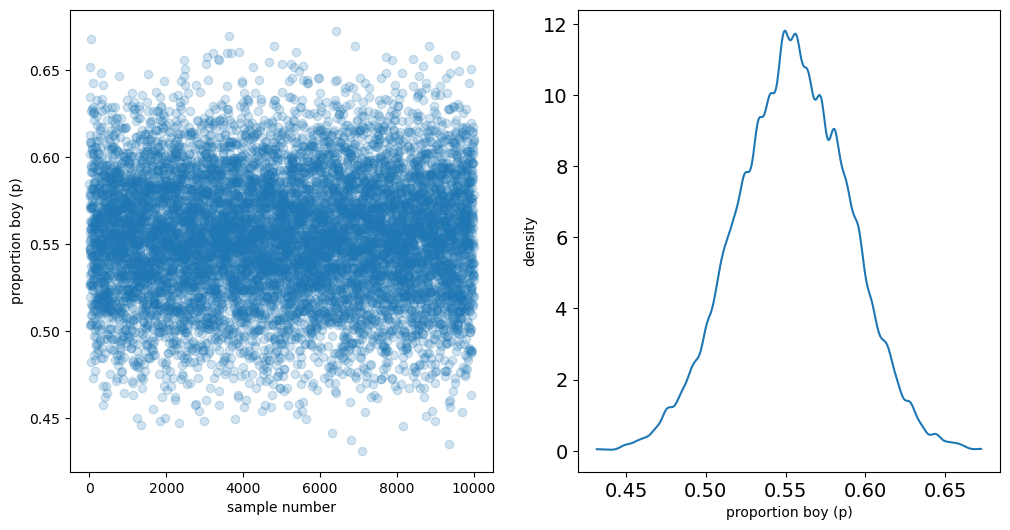

In [123]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion boy (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion boy (p)")
ax1.set_ylabel("density");

In [124]:
print(az.hdi(samples, hdi_prob=0.50))
print(az.hdi(samples, hdi_prob=0.89))
print(az.hdi(samples, hdi_prob=0.97))

[0.53253253 0.57957958]
[0.5005005  0.61261261]
[0.47547548 0.62762763]


### 3H3. Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to visualize the simulations, but the dens command (part of the rethinking package) is prbably the easiest way in this case. Does it look like the model fits the data well? That is, does the distribution of predictions include the actual observation as a central, likely outcome?

In [125]:
s = np.random.binomial(200, samples, 10000)

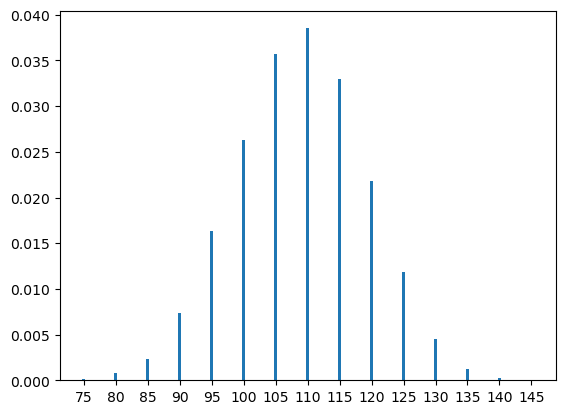

In [126]:
ax = az.plot_dist(s, kind="hist", hist_kwargs={"rwidth": 0.1})
plt.show()

### 3H4. Now compare 10,000 counts of boys from 100 simulated first borns only the number of boys in the first births, birth1. How does the model look in this light?

In [127]:
sum(birth1)

51

In [131]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=1000, water=51, tosses=100)

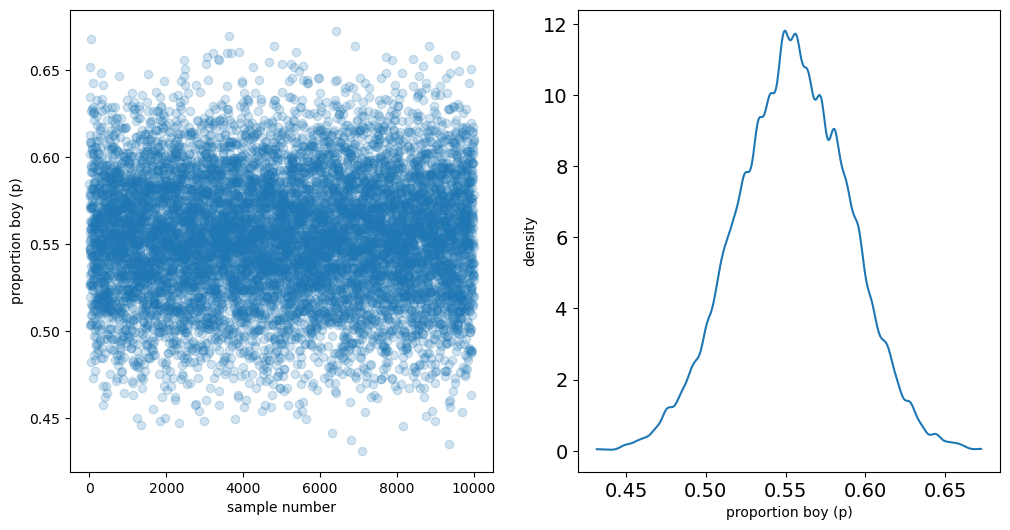

In [132]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion boy (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion boy (p)")
ax1.set_ylabel("density");

In [133]:
s = np.random.binomial(100, samples, 10000)

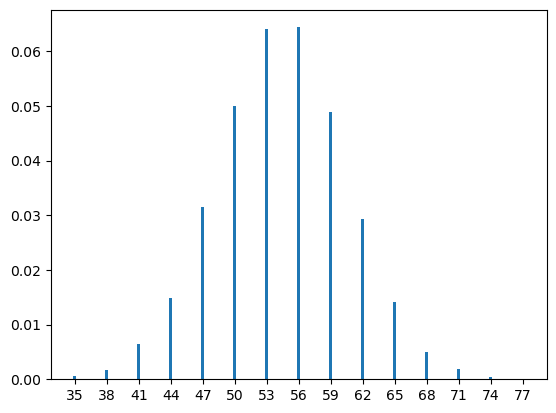

In [134]:
ax = az.plot_dist(s, kind="hist", hist_kwargs={"rwidth": 0.1})
plt.show()

### 3H5. The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated conts of boys to only those second births that followed girls. To do this correctly, you need to count the number of first borns who were girls and simulate that many births, 10,000 times. Compare the counts of boys in your simulations to the actual observed count of boys following girls. How does the model look in this light? Any guesses what is going on in these data?

In [136]:
100-sum(birth1)

49

In [137]:
s = np.random.binomial(49, samples, 10000)

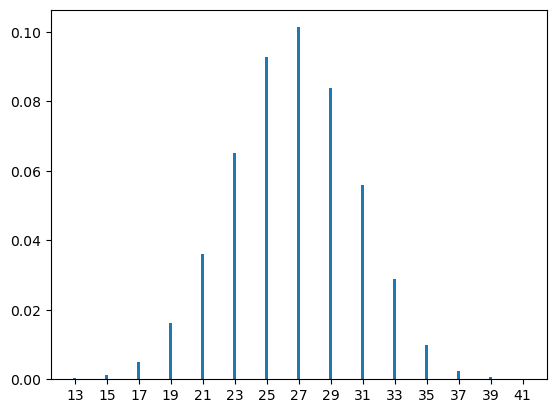

In [138]:
ax = az.plot_dist(s, kind="hist", hist_kwargs={"rwidth": 0.1})
plt.show()